In [8]:
import numpy as np
import random
import pickle

In [72]:
with open('out5.pkl', 'rb') as f:
    test_out = pickle.load(f)
    


In [73]:
test_out['PMP']['Roost']

array([0.0027826 , 0.19944906, 0.19956992, 0.24970974, 0.29846263,
       0.05002606])

In [11]:
patch_net = {0: {'Name': 'Roost', 'carrying_capacity': 1, 'init_resources': 0, 'resource_birth': 0,
                 'patch_center': [0.5,0.5], 'bat_resource_conversion': 0, 'Res':np.array([0,0])},
             1: {'Name': 'Residential', 'carrying_capacity': 1000, 'init_resources': 1000, 'resource_birth': 0.05,
                 'patch_center': [1.5,0.5], 'bat_resource_conversion': 0.9, 'Res':np.array([0,1])},
             2: {'Name': 'Residential 2', 'carrying_capacity': 1000, 'init_resources': 1000, 'resource_birth': 0.05,
                 'patch_center': [2.5,0.5], 'bat_resource_conversion': 0.9, 'Res':np.array([0,1])},
             3: {'Name': 'Orchard', 'carrying_capacity': 1000, 'init_resources': 1000, 'resource_birth': 0.01,
                 'patch_center': [0.5,1.5], 'bat_resource_conversion': 0.9, 'Res':np.array([1,0])},
             4: {'Name': 'Orchard 2', 'carrying_capacity': 1000, 'init_resources': 1000, 'resource_birth': 0.01,
                 'patch_center': [1.5,1.5], 'bat_resource_conversion': 0.9, 'Res':np.array([1,0])},
             5: {'Name': 'Dump', 'carrying_capacity': 500, 'init_resources': 100, 'resource_birth': 0.5,
                 'patch_center': [2.5,1.5], 'bat_resource_conversion': 0.9, 'Res':np.array([0,1])}}

In [12]:
patch_types = ['Roost', 'Residential', 'Orchard', 'Water Body', 'Forest', 'Dump']
patch_names = random.choices(patch_types,weights = [1/100, 20/100, 10/100,10/100,50/100, 9/100], k = 100)
while 'Roost' not in patch_names:
    patch_names = random.choices(patch_types,weights = [1/100, 20/100, 10/100,10/100,50/100, 9/100], k = 100)

In [13]:
#create patch network that is 10x10

patch_net_10x10 = {}
resources = np.zeros((10,10))
count = 0
K = np.random.choice(np.arange(1,500))
rb = 0#np.random.choice(np.arange(0,0.1,0.001))

for i in range(10):
    for j in range(10):
        patch_net_10x10[count] ={}
        patch_net_10x10[count]['Name']= patch_names[count]
        patch_net_10x10[count]['patch_center']= [i+0.5,j+0.5]
        patch_net_10x10[count]['carrying_capacity']= K
        patch_net_10x10[count]['init_resources']= np.random.choice(np.arange(1,K+1))
        resources[i,j]=patch_net_10x10[count]['init_resources']
        patch_net_10x10[count]['resource_birth'] = rb
        if patch_net_10x10[count]['Name'] in ['Residential','Dump']:
            patch_net_10x10[count]['Res']=np.array([0,1])
        elif patch_net_10x10[count]['Name'] in ['Orchard', 'Water Body', 'Forest']:
            patch_net_10x10[count]['Res']=np.array([1,0])
        else:
            patch_net_10x10[count]['Res']=np.array([0.5,0.5])
        count = count+1
            
            

In [14]:
import pickle 

with open('test_small_synth_patch_net.pkl', 'wb') as f:
    pickle.dump(patch_net_10x10, f)


In [15]:
rb

0

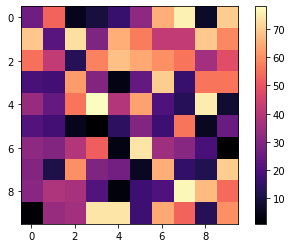

In [16]:
import matplotlib.pyplot as plt
data=np.array(resources)
plt.imshow(data,cmap='magma')
plt.colorbar()
plt.show()

In [102]:
print(np.mean(resources))
print(np.max(resources))

86.49
175.0


In [103]:
patch_type_dist = np.zeros(len(patch_types))
for p in patch_names:
    if p=='Roost':
        patch_type_dist[0]+=1
    if p=='Residential':
        patch_type_dist[1]+=1
    if p=='Orchard':
        patch_type_dist[2]+=1
    if p=='Water Body':
        patch_type_dist[3]+=1
    if p=='Forest':
        patch_type_dist[4]+=1
    if p=='Dump':
        patch_type_dist[5]+=1

patch_probs = np.array([0.        , 0.53710742, 0.26605321, 0.06561312, 0.06561312,
       0.06561313])

patch_dist = np.zeros(len(patch_names))
count = 0
for p in patch_names:
    if p=='Roost':
        patch_dist[count]=0
    if p=='Residential':
        patch_dist[count]=patch_probs[1]/patch_type_dist[1]
    if p=='Orchard':
        patch_dist[count]=patch_probs[2]/patch_type_dist[2]
    if p=='Water Body':
        patch_dist[count]=patch_probs[3]/patch_type_dist[3]
    if p=='Forest':
        patch_dist[count]=patch_probs[4]/patch_type_dist[4]
    if p=='Dump':
        patch_dist[count]=patch_probs[5]/patch_type_dist[5]
    count = count+1

In [104]:
with open('init_small_synth_forage.pkl', 'wb') as f:
    pickle.dump(patch_dist, f)

# Creating synthetic landscapes for testing mitigation strategies
 - equal parts
 - mostly forrest
 - mostly orchard
 - mostly residential
 
 Decide what proportion of the grid should be each type. Start with residential, pick random grid space and assign to type. Assign neighboring types with some probability. Repeat while not filled
 

In [17]:
def get_neighbours_ij(m,x,y,neighbors):
    rows, cols = range(len(m)),range(len(m[0]))
    offsets = [(-1,-1),(-1,0),(-1,1),(0,-1),(0,1),(1,-1),(1,0),(1,1)]
    for dy,dx in offsets:
        ny, nx = y+dy, x+dx
        if ny in rows and nx in cols:
            neighbors.append([ny,nx])
    return neighbors

In [18]:
patch_net = {}
patch_names = []
num_patches = 3*3
patch_type_nums = np.round(np.array([0.2,0.2,0.2,0.2,0.2])*num_patches)
types = -1*np.ones((3,3))
neighbors = []
type_options = np.array([0,1,2,3,4])

i = random.choice(np.arange(3))
j = random.choice(np.arange(3))

In [19]:
resources_map = { 0: ['Orchard', 2000,5000,0.05,0.1],
                  1: ['Forest', 1000,3000,0.0,0.1],
                  2: ['Residential',500,1000,0.1,0.5],
                  3: ['Dump', 200,1000,0.1,0.5],
                  4: ['Water Body',100,3000,0.0,0.1]
                }

color_map = { 0: np.array([255,255,100]),
              1: np.array([30,114,36]),
              2: np.array([195,20,0]),
              3: np.array([0,0,0]),
              4: np.array([0,45,195])
            }

def get_neighbours(m,x,y):
    rows, cols = range(len(m)),range(len(m[0]))
    offsets = [(-1,-1),(-1,0),(-1,1),(0,-1),(0,1),(1,-1),(1,0),(1,1)]
    result = []
    for dy,dx in offsets:
        ny, nx = y-1+dy, x-1+dx
        if ny in rows and nx in cols:
            result.append(resources_map[m[ny,nx]][0])
    return np.array(result)

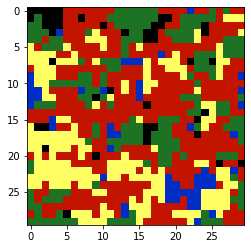

In [108]:
import numpy as np
import random

def create_strongly_clustered_matrix(rows, cols, proportions):
    """
    Create a matrix with values 0,1,2,3,4 based on given proportions, with stronger clustering.
    
    Args:
    rows (int): Number of rows in the matrix.
    cols (int): Number of columns in the matrix.
    proportions (list of float): A list of 5 floats representing the proportions of each value.
    
    Returns:
    np.ndarray: A matrix with values 0,1,2,3,4 arranged in strong clusters.
    """
    # Number of values (0,1,2,3,4)
    values = [0, 1, 2, 3, 4]
    
    # Calculate the total number of elements in the matrix
    total_elements = rows * cols
    
    # Calculate how many of each value we need based on the proportions
    counts = [int(p * total_elements) for p in proportions]
    
    # Ensure that the sum of the counts equals the total number of elements
    while sum(counts) < total_elements:
        counts[random.randint(0, 4)] += 1
    while sum(counts) > total_elements:
        counts[random.randint(0, 4)] -= 1
    
    # Initialize the matrix with -1 (to represent unfilled cells)
    matrix = np.full((rows, cols), -1)
    
    # Function to get the neighbors of a cell
    def get_neighbors(r, c):
        neighbors = []
        if r > 0:
            neighbors.append((r-1, c))  # up
        if r < rows-1:
            neighbors.append((r+1, c))  # down
        if c > 0:
            neighbors.append((r, c-1))  # left
        if c < cols-1:
            neighbors.append((r, c+1))  # right
        return neighbors

    # Step 1: Seed initial positions for each value
    positions = [(r, c) for r in range(rows) for c in range(cols)]
    random.shuffle(positions)  # Shuffle to randomize seeding
    
    for value, count in zip(values, counts):
        # Place a few random initial seeds for each value
        initial_seeds = count // 5  # Spread out initial seeds
        for _ in range(initial_seeds):
            r, c = random.choice(positions)
            matrix[r, c] = value
            positions.remove((r, c))  # Remove this position from the list

    # Step 2: Cluster expansion
    for value, count in zip(values, counts):
        remaining = count - (count // 5)  # Remaining elements to be placed
        while remaining > 0:
            # Expand from already placed cells of the current value
            expansion_candidates = [(r, c) for r in range(rows) for c in range(cols) if matrix[r, c] == value]
            if not expansion_candidates:
                break  # No more places to expand from
            
            # Try to expand around each candidate
            expanded = False
            random.shuffle(expansion_candidates)  # Randomize the order of candidates
            for r, c in expansion_candidates:
                neighbors = get_neighbors(r, c)
                random.shuffle(neighbors)  # Randomize the neighbor selection
                for nr, nc in neighbors:
                    if matrix[nr, nc] == -1:  # Unfilled spot
                        matrix[nr, nc] = value
                        remaining -= 1
                        expanded = True
                        break
                if expanded:
                    break
            
            # If we can't expand from any current cluster, we break out of the loop to avoid infinite loops
            if not expanded:
                break

    # Step 3: Fill remaining spots randomly (if any gaps)
    remaining_positions = [(r, c) for r in range(rows) for c in range(cols) if matrix[r, c] == -1]
    random.shuffle(remaining_positions)
    
    for r, c in remaining_positions:
        # Pick a value to fill, weighted by the remaining counts
        value = random.choices(values, weights=counts, k=1)[0]
        matrix[r, c] = value
        counts[values.index(value)] -= 1  # Decrease the remaining count for that value
    
    return matrix

# Example usage
rows = 30
cols = 30
proportions = [0.2, 0.2, 0.4, 0.1, 0.1]  # Proportions for values 0, 1, 2, 3, 4
#{ ['Orchard', 'Forest','Residential','Dump','Water Body']
matrix = create_strongly_clustered_matrix(rows, cols, proportions)


data_3d = np.ndarray(shape=(rows,cols, 3), dtype=int)
for r in range(rows):
    for c in range(cols):
        data_3d[r][c]= color_map[matrix[r][c]]
fig, ax = plt.subplots()
ax.imshow(data_3d)
plt.show()


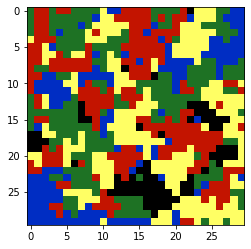

In [143]:
import numpy as np
import random

def create_strongly_clustered_matrix(rows, cols, proportions):
    """
    Create a matrix with values 0,1,2,3,4 based on given proportions, with stronger clustering.
    
    Args:
    rows (int): Number of rows in the matrix.
    cols (int): Number of columns in the matrix.
    proportions (list of float): A list of 5 floats representing the proportions of each value.
    
    Returns:
    np.ndarray: A matrix with values 0,1,2,3,4 arranged in strong clusters.
    """
    # Values that we want to distribute
    values = [0, 1, 2, 3, 4]
    
    # Total number of elements in the matrix
    total_elements = rows * cols
    
    # Calculate how many of each value we need based on the proportions
    counts = np.array([int(p * total_elements) for p in proportions])
    
    # Ensure that the sum of the counts equals the total number of elements
    while sum(counts) < total_elements:
        counts[random.choice(np.where(counts>0))] += 1
    while sum(counts) > total_elements:
        counts[random.choice(np.where(counts>0))] -= 1
    
    # Filter out values with zero count and remove them from the process entirely
    non_zero_values = [v for v, count in zip(values, counts) if count > 0]
    non_zero_counts = [count for count in counts if count > 0]
    
    # Initialize the matrix with -1 to represent unfilled cells
    matrix = np.full((rows, cols), -1)
    
    def get_neighbors(r, c):
        """Return the neighboring cells of (r, c)"""
        neighbors = []
        if r > 0:
            neighbors.append((r-1, c))  # up
        if r < rows-1:
            neighbors.append((r+1, c))  # down
        if c > 0:
            neighbors.append((r, c-1))  # left
        if c < cols-1:
            neighbors.append((r, c+1))  # right
        return neighbors
    
    # Step 1: Seed initial positions for each value
    positions = [(r, c) for r in range(rows) for c in range(cols)]
    random.shuffle(positions)
    
    for value, count in zip(non_zero_values, non_zero_counts):
        initial_seeds = count // 5  # Spread out initial seeds
        for _ in range(initial_seeds):
            if not positions:
                break
            r, c = random.choice(positions)
            matrix[r, c] = value
            positions.remove((r, c))
    
    # Step 2: Cluster expansion
    for value, count in zip(non_zero_values, non_zero_counts):
        remaining = count - (count // 5)  # Remaining elements to be placed
        while remaining > 0:
            expansion_candidates = [(r, c) for r in range(rows) for c in range(cols) if matrix[r, c] == value]
            if not expansion_candidates:
                break
            
            expanded = False
            random.shuffle(expansion_candidates)
            for r, c in expansion_candidates:
                neighbors = get_neighbors(r, c)
                random.shuffle(neighbors)
                for nr, nc in neighbors:
                    if matrix[nr, nc] == -1:  # Unfilled spot
                        matrix[nr, nc] = value
                        remaining -= 1
                        expanded = True
                        break
                if expanded:
                    break
            
            if not expanded:
                break

    # Step 3: Fill remaining spots with non-zero counts
    remaining_positions = [(r, c) for r in range(rows) for c in range(cols) if matrix[r, c] == -1]
    random.shuffle(remaining_positions)
    
    while remaining_positions:
        r, c = remaining_positions.pop()
        
        # Only use non-zero values for filling
        value = random.choices(non_zero_values, weights=non_zero_counts, k=1)[0]
        matrix[r, c] = value
        
        # Decrease the count for that value
        value_index = non_zero_values.index(value)
        non_zero_counts[value_index] -= 1
        
        # If a count reaches zero, remove that value from the list
        if non_zero_counts[value_index] == 0:
            non_zero_values.pop(value_index)
            non_zero_counts.pop(value_index)
    
    return matrix


# Example usage
rows = 30
cols = 30
proportions = [0.2, 0.2, 0.2, 0.05, 0.15]  # Proportions for values 0, 1, 2, 3, 4
matrix = create_strongly_clustered_matrix(rows, cols, proportions)
#['Orchard','Forest','Residential','Dump','Water Body']

data_3d = np.ndarray(shape=(rows,cols, 3), dtype=int)
for r in range(rows):
    for c in range(cols):
        data_3d[r][c]= color_map[matrix[r][c]]
fig, ax = plt.subplots()
ax.imshow(data_3d)
plt.show()

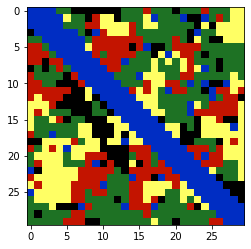

In [110]:
import numpy as np
import random

def replace_values_with_clustering(matrix, proportion, value):
    """
    Replace values in a matrix with a specified value, clustered near the diagonal, according to the given proportion.
    
    Args:
    matrix (np.ndarray): The input matrix.
    proportion (float): The proportion of the matrix to be replaced with the given value.
    value (int): The value to insert in the matrix.
    
    Returns:
    np.ndarray: The modified matrix with clustered values near the diagonal.
    """
    rows, cols = matrix.shape
    total_elements = rows * cols
    elements_to_replace = int(proportion * total_elements)

    # Generate positions near the diagonal
    diagonal_positions = []
    for r in range(rows):
        for c in range(cols):
            # Prioritize cells closer to the diagonal (i.e., |r - c| is small)
            if abs(r - c) <= 2:  # Allow some variation off the main diagonal for clustering
                diagonal_positions.append((r, c))

    # Randomly shuffle the diagonal positions
    random.shuffle(diagonal_positions)

    # Ensure there are enough positions to replace
    if elements_to_replace > len(diagonal_positions):
        # Add additional positions if needed
        additional_positions_needed = elements_to_replace - len(diagonal_positions)
        non_diagonal_positions = [(r, c) for r in range(rows) for c in range(cols) if abs(r - c) > 2]
        random.shuffle(non_diagonal_positions)
        diagonal_positions.extend(non_diagonal_positions[:additional_positions_needed])

    # Select the exact number of positions needed
    selected_positions = diagonal_positions[:elements_to_replace]

    # Replace the selected positions in the matrix with the given value
    for r, c in selected_positions:
        matrix[r, c] = value
    
    return matrix

# Example usage
rows = 30
cols = 30
proportions = [0.2, 0.3, 0.2, 0.2, 0.0]  # Proportions for values 0, 1, 2, 3, 4
matrix = create_strongly_clustered_matrix(rows, cols, proportions)

proportion = 0.2  # Replace 20% of the matrix
value = 4  # Replace with the value 4

modified_matrix = replace_values_with_clustering(matrix, proportion, value)

data_3d = np.ndarray(shape=(rows,cols, 3), dtype=int)
for r in range(rows):
    for c in range(cols):
        data_3d[r][c]= color_map[modified_matrix[r][c]]
fig, ax = plt.subplots()
ax.imshow(data_3d)
plt.show()




# create matrix with k clusters of each type to make the given proportion

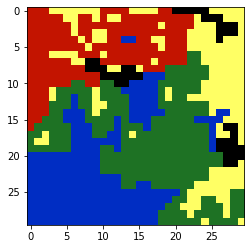

In [283]:
def get_neighbors(r, c):
    """Return the neighboring cells of (r, c)"""
    neighbors = []
    if r > 0:
        neighbors.append((r-1, c))  # up
    if r < rows-1:
        neighbors.append((r+1, c))  # down
    if c > 0:
        neighbors.append((r, c-1))  # left
    if c < cols-1:
        neighbors.append((r, c+1))  # right
    return neighbors

def place_cluster(matrix,rows, cols,num_val,val,replace):
    if num_val == 0:
        return matrix
    matrix_new = np.copy(matrix)
    clustered = []
    x = np.random.choice(np.arange(rows))
    xprev = x
    y = np.random.choice(np.arange(cols))
    yprev=y
    while matrix[x,y] != replace:
        x = np.random.choice(np.arange(rows))
        y = np.random.choice(np.arange(cols))
    clustered.append([x,y])
    matrix_new[x,y] = val
    num_val -=1
    
    while num_val>0:
        xprev = x
        yprev = y
        
        #look at neighbors
        neighbors=get_neighbors(x, y)
        replaceable = np.array([n for n in neighbors if matrix_new[n]==replace])
        if len(replaceable)>0:
            x,y = replaceable[np.random.choice(np.arange(len(replaceable)))]
            matrix_new[x,y] = val
            clustered.append([x,y])
            num_val -=1
        else:
            for el in clustered:
                neighbors=get_neighbors(el[0],el[1])
                replaceable = np.array([n for n in neighbors if matrix_new[n]==replace])
                if len(replaceable)>0:
                    x,y = replaceable[np.random.choice(np.arange(len(replaceable)))]
                    matrix_new[x,y] = val
                    clustered.append([x,y])
                    num_val -=1
                    break

        if xprev==x and yprev==y:
            x = np.random.choice(np.arange(rows))
            y = np.random.choice(np.arange(cols))
            while matrix_new[x,y] != replace:
                x = np.random.choice(np.arange(rows))
                y = np.random.choice(np.arange(cols))
            clustered.append([x,y])
            matrix_new[x,y] = val
            num_val -=1
   
    return matrix_new,num_val
    

def generate_clustered_matrix(rows, cols, proportions, clusters_per_value):
    matrix = np.zeros((rows,cols))
    num_el = (rows*cols)*proportions
    el_per_cluster = num_el/clusters_per_value
    for i in range(len(clusters_per_value)):
        for j in range(clusters_per_value[i]):
            [matrix,num_val] =place_cluster(matrix,rows, cols,int(el_per_cluster[i]),i+1,0)
    return matrix
   

rows, cols = 30, 30
proportions = np.array([0.3, 0.2, 0.05, 0.25])  
# Equal proportion for each value
clusters_per_value = np.array([1, 3, 3, 1])  
# Specify 3 clusters for each of values 1, 2, 3, and 4
#[0,1,2,3,4]
#[orchard,forest,residential,dump,waterbody]
matrix = generate_clustered_matrix(rows, cols, proportions, clusters_per_value)

data_3d = np.ndarray(shape=(rows,cols, 3), dtype=int)
for r in range(rows):
    for c in range(cols):
        data_3d[r][c]= color_map[matrix[r][c]]
fig, ax = plt.subplots()
ax.imshow(data_3d)
plt.show()

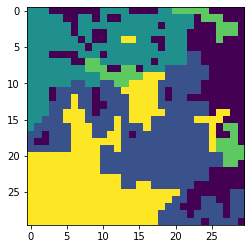

In [50]:
#matrix_good = matrix.copy()
#with open('base_fragmentation_matrix.pkl', 'wb') as f:
#    pickle.dump(matrix_good, f)

with open('base_fragmentation_matrix.pkl', 'rb') as f:
    matrix_good = pickle.load(f)
    
plt.imshow(matrix_good.reshape(30,30))

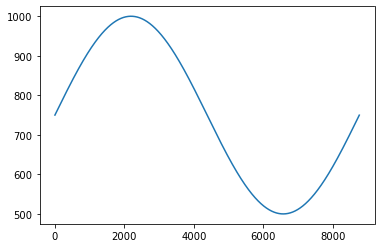

In [21]:
t = np.arange(365*24)
K = 1000
r_test = (K/4)*np.sin(2*np.pi/(24*365)*t)+(3*K/4)
plt.plot(t, r_test)

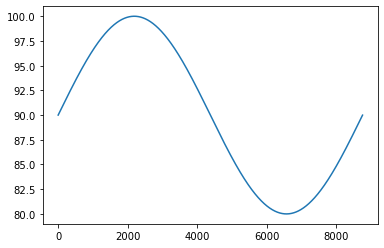

In [22]:
t = np.arange(365*24)
K = 100
r_test = (K/10)*np.sin(2*np.pi/(24*365)*t)+(9*K/10)
plt.plot(t, r_test)

In [23]:
#function for creating patch network from matrix
def create_patch_net(matrix,resources_map):
    patch_net = {}
    patch_names = []
    dim =np.shape(matrix)
    data_3d = np.ndarray(shape=(dim[0],dim[1], 3), dtype=int)
    types = np.zeros((dim[0],dim[1]))
    p_ids = np.zeros((dim[0],dim[1]))
    xs = np.zeros((dim[0],1))
    ys = np.zeros((dim[1],1))
    t = np.arange(365*24)
    count = 0
    for i in range(dim[0]):
        for j in range(dim[1]):
            patch_net[count] = {}
            patch_net[count]['patch_center']= [i+0.5,j+0.5]
            p_type = matrix[i,j]
            data_3d[i][j]= color_map[p_type]
            types[i][j] = p_type
            p_ids[i][j] = count
            xs[i] = i+0.5
            ys[j] = j+0.5
            attr = resources_map[p_type]
            K = np.random.choice(np.arange(attr[1],attr[2]))
            patch_net[count]['max_cc']= K
            if p_type in [0,1,4]:
                patch_net[count]['carrying_capacity_yr'] = (K/4)*np.sin(2*np.pi/(24*365)*t)+(3*K/4)
            else:
                patch_net[count]['carrying_capacity_yr'] = (K/10)*np.sin(2*np.pi/(24*365)*t)+(9*K/10)
                
            patch_net[count]['p_type'] = p_type
            patch_net[count]['init_resources']= np.random.choice(np.arange(0,K))
            patch_net[count]['resource_birth'] = np.random.choice(np.arange(attr[3],attr[4],0.001))
            patch_net[count]['Name'] = attr[0]
            patch_net[count]['mat_index'] = [i,j]
            patch_names.append(patch_net[count]['Name'])
            count = count + 1
    neighbors_dict = {}
    is_edge = []
    near_or_is_water = []
    count = 0
    for i in range(dim[0]):
        for j in range(dim[1]):
            neighbors_dict[count] = get_neighbours(types.T,i+1,j+1)
            is_edge.append(len(np.where(neighbors_dict[count]=='Forest')[0])>0 and len(np.where(neighbors_dict[count]=='Forest')[0])<len(neighbors_dict[count]))
            near_or_is_water.append('Water Body' in neighbors_dict[count] or resources_map[types[i,j]][0]=='Water Body')
            count = count+1

    count = 0
    for i in range(dim[0]):
        for j in range(dim[1]):
            patch_net[count]['forrest_edge'] = is_edge[count]
            patch_net[count]['water_prox'] = near_or_is_water[count]
            count = count+1
    return patch_net

In [51]:
resources_map = { 0: ['Orchard', 2000,10000,0.05,0.1],
                  1: ['Forest', 1000,5000,0.05,0.1],
                  2: ['Residential',50,100,0.1,0.5],
                  3: ['Dump', 20,100,0.1,0.5],
                  4: ['Water Body',10,200,0.05,0.1]
                }

test_pn = create_patch_net(matrix_good,resources_map)

In [52]:
def determine_roost_locations(patch_network, min_num, max_num, type_pref):
    num_roosts = np.random.choice(np.arange(min_num,max_num))
    patches_of_pref = np.array([p for p in patch_network.keys() if patch_network[p]['p_type']==type_pref])
    roosts = random.choices(patches_of_pref,k=num_roosts)
    for r in roosts:
        patch_network[r]['Name']='Roost'
    return patch_network
    

In [53]:
test_pn_roosts = determine_roost_locations(test_pn, 1, 3, 1)

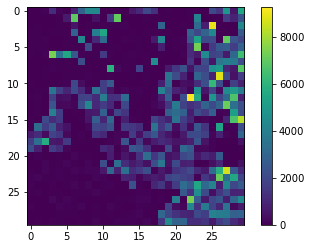

In [54]:
rec = np.array([test_pn_roosts[p]['init_resources'] for p in test_pn_roosts.keys()])
plt.imshow(rec.reshape(30,30))
plt.colorbar()

In [69]:
def get_neighbours_nonsimilar(m,x,y,neighbors,remove_type):
    rows, cols = range(len(m)),range(len(m[0]))
    offsets = [(-1,-1),(-1,0),(-1,1),(0,-1),(0,1),(1,-1),(1,0),(1,1)]
    for dy,dx in offsets:
        ny, nx = y+dy, x+dx
        if ny in rows and nx in cols:
            if m[nx,ny]!= remove_type and m[nx,ny]!= 4:
                neighbors.append([nx,ny])
    return neighbors

def get_key_from_mat_index(patch_net,index):
    keys = np.array(list(patch_net.keys()))
    indices = np.array([patch_net[p]['mat_index'] for p in keys])
    bools = np.zeros(len(keys))
    count = 0
    for i in indices:
        bools[count]=sum(i==index)
        count += 1
    key = keys[np.where(bools==2)][0]
    return key

def change_habitat_fragmentation(patch_net,matrix,fragment_type,neighbor_break, rows,cols):
    #break up the cluster by switching places with neighboring types (if not waterbody)
    #starting with edges
    patch_net_new = patch_net.copy()
    matrix_new = matrix.copy()
    patches_of_type = np.array([patch_net_new[p]['mat_index'] for p in patch_net_new.keys() if patch_net_new[p]['p_type']==fragment_type])
    
    #check neighbors for each patch in patches of type
    neighbors = []
    for p in patches_of_type:
        neighbors.append(get_neighbours_nonsimilar(matrix,p[0],p[1],[],1))
    
    for n in range(len(neighbors)):
        #if the number of non-fragment_type neighbors is >= neighbor_break, fragment
        if len(neighbors[n])>=neighbor_break:
            #switch places with random neighbor in the network
            to_switch_ind = np.random.choice(np.arange(len(neighbors[n])))
            to_switch = neighbors[n][to_switch_ind]
            key_to_switch1 = get_key_from_mat_index(patch_net_new,to_switch)
            key_to_switch2 = get_key_from_mat_index(patch_net_new,patches_of_type[n])
            temp1 = patch_net_new[key_to_switch1]
            temp2 = patch_net_new[key_to_switch2]
            patch_net_new[key_to_switch1] = temp2
            patch_net_new[key_to_switch2] = temp1
            matrix_new[patches_of_type[n][0],patches_of_type[n][1]]=matrix[to_switch[0],to_switch[1]]
            matrix_new[to_switch[0],to_switch[1]] = fragment_type
    
    data_3d = np.ndarray(shape=(rows,cols, 3), dtype=int)
    for r in range(rows):
        for c in range(cols):
            data_3d[r][c]= color_map[matrix_new[r][c]]
    fig, ax = plt.subplots()
    ax.imshow(data_3d)
    plt.show()
    return [patch_net_new,matrix_new]


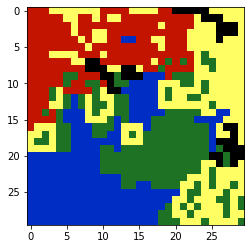

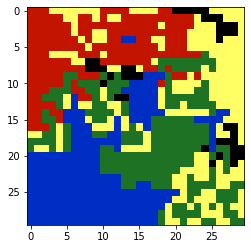

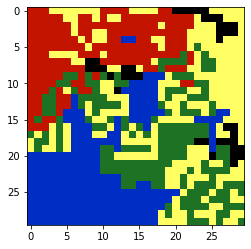

In [71]:
### dists = direct_paths_dist(test_pn_roosts)
for i in range(len(test_pn_roosts.keys())):
    test_pn_roosts[i]['dist'] = dists[i,:]
with open('fragmentation_net_base.pkl', 'wb') as f:
    pickle.dump(test_pn_roosts, f)
    
[patch_net_new,matrix_new]=change_habitat_fragmentation(test_pn_roosts,matrix_good,1,1,30,30)
dists = direct_paths_dist(patch_net_new)
for i in range(len(patch_net_new.keys())):
    patch_net_new[i]['dist'] = dists[i,:]
with open('fragmentation_net_i1.pkl', 'wb') as f:
    pickle.dump(patch_net_new, f)

    
[patch_net_new2,matrix_new2]=change_habitat_fragmentation(patch_net_new,matrix_new,1,1,30,30)
dists = direct_paths_dist(patch_net_new2)
for i in range(len(patch_net_new2.keys())):
    patch_net_new2[i]['dist'] = dists[i,:]
with open('fragmentation_net_i2.pkl', 'wb') as f:
    pickle.dump(patch_net_new2, f)


[patch_net_new3,matrix_new3]=change_habitat_fragmentation(patch_net_new2,matrix_new2,1,1,30,30)
dists = direct_paths_dist(patch_net_new3)
for i in range(len(patch_net_new3.keys())):
    patch_net_new3[i]['dist'] = dists[i,:]
with open('fragmentation_net_i3.pkl', 'wb') as f:
    pickle.dump(patch_net_new3, f)

# Precalculate preferred paths
- direct paths
- avoid residential
- close to water
- close to forest

resources_map = { 0: ['Orchard', 2000,5000,0.05,0.1],
                  1: ['Forest', 1000,3000,0.0,0.1],
                  2: ['Residential',500,1000,0.1,0.5],
                  3: ['Dump', 200,1000,0.1,0.5],
                  4: ['Water Body',100,3000,0.0,0.1]
                }

In [30]:
resources_map = { 0: ['Orchard', 2000,5000,0.05,0.1],
                  1: ['Forest', 1000,2500,0.0,0.1],
                  2: ['Residential',50,100,0.1,0.5],
                  3: ['Dump', 20,100,0.1,0.5],
                  4: ['Water Body',1000,2500,0.0,0.1]
                }

#resources_map = { 0: ['Orchard', 2000,5000,0.05,0.1], 
#                  1: ['Forest', 10,30,0.0,0.1], 
#                  2: ['Residential',5,10,0.1,0.5], 
#                  3: ['Dump', 2,10,0.1,0.5], 
#                  4: ['Water Body',1,30,0.0,0.1] 
#                 }

In [31]:
# test matrix
rows = 10
cols = 10
proportions = [0.2, 0.1, 0.5, 0.1, 0.1]  # Proportions for values 0, 1, 2, 3, 4
matrix = create_strongly_clustered_matrix(rows, cols, proportions)


data_3d = np.ndarray(shape=(rows,cols, 3), dtype=int)
for r in range(rows):
    for c in range(cols):
        data_3d[r][c]= color_map[matrix[r][c]]
fig, ax = plt.subplots()
ax.imshow(data_3d)
plt.show()

patch_net = {}
patch_names = []
data_3d = np.ndarray(shape=(10,10, 3), dtype=int)
types = np.zeros((10,10))
p_ids = np.zeros((10,10))
xs = np.zeros((10,1))
ys = np.zeros((10,1))
count = 0
for i in range(10):
    for j in range(10):
        patch_net[count] = {}
        patch_net[count]['patch_center']= [i+0.5,j+0.5]
        p_type = matrix[i,j]
        data_3d[i][j]= color_map[p_type]
        types[i][j] = p_type
        p_ids[i][j] = count
        xs[i] = i+0.5
        ys[j] = j+0.5
        attr = resources_map[p_type]
        K = np.random.choice(np.arange(attr[1],attr[2]))
        patch_net[count]['max_cc']= K
        patch_net[count]['p_type'] = p_type
        patch_net[count]['init_resources']= np.random.choice(np.arange(0,K))
        patch_net[count]['resource_birth'] = np.random.choice(np.arange(attr[3],attr[4],0.001))
        patch_net[count]['Name'] = attr[0]
        patch_names.append(patch_net[count]['Name'])
        count = count + 1

# display the plot 
#fig, ax = plt.subplots()
#ax.imshow(data_3d)
#plt.show()


neighbors_dict = {}
is_edge = []
near_or_is_water = []
count = 0
for i in range(10):
    for j in range(10):
        neighbors_dict[count] = get_neighbours(types.T,i+1,j+1)
        is_edge.append(len(np.where(neighbors_dict[count]=='Forest')[0])>0 and len(np.where(neighbors_dict[count]=='Forest')[0])<len(neighbors_dict[count]))
        near_or_is_water.append('Water Body' in neighbors_dict[count] or resources_map[types[i,j]][0]=='Water Body')
        count = count+1

count = 0
for i in range(10):
    for j in range(10):
        patch_net[count]['forrest_edge'] = is_edge[count]
        patch_net[count]['water_prox'] = near_or_is_water[count]
        count = count+1
        
#fig, ax = plt.subplots()
#plt.imshow(np.array(is_edge).reshape(types.shape))
#plt.colorbar()
#plt.show()
#fig, ax = plt.subplots()
#plt.imshow(np.array(near_or_is_water).reshape(types.shape))
#plt.colorbar()
#plt.show()

classes_multi =np.zeros(types.shape)
classes_multi=types
count = 0
t = np.arange(365*24)
for i in range(classes_multi.shape[0]):
    for j in range(classes_multi.shape[1]):
        k1 = patch_net[count]['max_cc']
        patch_net[count]['carrying_capacity_yr'] = k1*np.cos(2*np.pi/(24*365)*t)+k1
        if i==10 and j==10:
            patch_net[count]['Name']='Roost'
        if i==5 and j==20:
            patch_net[count]['Name']='Roost'
        if i==17 and j==20:
            patch_net[count]['Name']='Roost'
        count=count+1

        
resources = np.asarray([patch_net[i]['init_resources'] for i in range(count)])

data=np.array(resources.reshape(types.shape))
plt.imshow(data,cmap='magma')
plt.colorbar()
plt.show()

patch_net_rand = patch_net.copy()

NameError: name 'create_strongly_clustered_matrix' is not defined

In [32]:
def direct_paths_dist(patch_net):
    direct_paths = []
    centers_xs = np.array([patch_net[p]['patch_center'][0] for p in patch_net.keys()])
    centers_ys = np.array([patch_net[p]['patch_center'][1] for p in patch_net.keys()])
    for p in patch_net.keys():
        p_coord = patch_net[p]['patch_center']
        x = p_coord[0]
        y = p_coord[1]
        direct_paths.append(np.sqrt((centers_xs - x) ** 2 + (centers_ys - y) ** 2))
    return np.array(direct_paths)

In [33]:
test = direct_paths_dist(patch_net_rand)
patch_net_rand[30]['Name']='Roost'
patch_net_rand[75]['Name']='Roost'
patch_net_rand[4]['Name']='Roost'
for i in range(len(patch_net_rand.keys())):
    patch_net_rand[i]['dist'] = test[i,:]

NameError: name 'patch_net_rand' is not defined

In [34]:
with open('small_synth_clustered_residential.pkl', 'wb') as f:
    pickle.dump(patch_net_rand, f)

NameError: name 'patch_net_rand' is not defined

In [35]:
test.shape

NameError: name 'test' is not defined

In [36]:
plt.imshow(test[0].reshape((10,10))) #time in hrs
plt.colorbar()

NameError: name 'test' is not defined

In [37]:
def path_on_grid_direct(start, end,ax):
    #return line for plotting
    start_coord = patch_net[start]['patch_center']
    x_start = start_coord[0]
    y_start = start_coord[1]
    
    end_coord = patch_net[end]['patch_center']
    x_end = end_coord[0]
    y_end = end_coord[1]
    
    if x_end==x_start:
        ax.vlines(x = x_start, ymin = min(y_start,y_end), ymax = max(y_start,y_end))
    elif y_end==y_start:
        ax.hlines(y = y_start, xmin = min(x_start,x_end), xmax = max(x_start,x_end))
    else:
        m = ((y_end-y_start)/(x_end-x_start))
        line = m*np.arange(x_start, x_end+1,1) + (y_start-(m*x_start))
        ax.plot(np.arange(x_start, x_end+1,1),line)

def path_on_grid_direct_next_point(start,end):
    #return line for plotting
    start_coord = patch_net[start]['patch_center']
    x_start = start_coord[0]
    y_start = start_coord[1]
    
    end_coord = patch_net[end]['patch_center']
    x_end = end_coord[0]
    y_end = end_coord[1]
    
    if start==end:
        return end
    elif x_end==x_start:
        cx,cy = np.where(p_ids==start)
        if start<end:
            return int(p_ids[cx,cy+1]) 
        else:
            return int(p_ids[cx,cy-1])
    elif y_end==y_start:
        cx,cy = np.where(p_ids==start)
        if start<end:
            return int(p_ids[cx+1,cy]) 
        else:
            return int(p_ids[cx-1,cy])
    else:
        m = ((y_end-y_start)/(x_end-x_start))
        if x_start<x_end:
            x_range = np.arange(x_start, x_end+0.001,0.001)
        else:
            x_range = np.arange(x_end, x_start+0.001,0.001)
        line = m*x_range + (y_start-(m*x_start))
        check = line - y_start
        y_val = line[np.where(abs(line - y_start)>0.5)][0]
        x_val = x_range[np.where(abs(line - y_start)>0.5)][0]
        return int(p_ids[np.argmin(abs(xs-x_val)),np.argmin(abs(ys-y_val))])

In [38]:
def plot_pairs(pairs):
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_ylim(ymin=0, ymax = 10)
    ax.set_xlim(xmin=0, xmax = 10)
    #pairs are p_ids
    for p in pairs:
        path_on_grid_direct(p[0],p[1], ax)
#plot_pairs(np.array([[0,200],[200,50],[50,600]]))

In [39]:
def get_neighbours_path(m,p):#p_ids,p_id
    x = int(np.where(p_ids==p)[0])
    y = int(np.where(p_ids==p)[1])
    rows, cols = range(len(m)),range(len(m[0]))
    offsets = [(-1,-1),(-1,0),(-1,1),(0,-1),(0,1),(1,-1),(1,0),(1,1)]
    result = []
    for dy,dx in offsets:
        ny, nx = y+dy, x+dx
        if ny in rows and nx in cols:
            result.append(m[nx,ny])
    return result

In [40]:
def path_on_grid_preference_next_point(start,end,pref_type,path):
    next_direct = path_on_grid_direct_next_point(start,end)
    #check p_type of next direct
    if patch_net[next_direct]['p_type'] in pref_type:
        return next_direct
    else:
        #look at neighbors
        neighbors = get_neighbours_path(p_ids,start)
        # which neighbors are in correct direction (overlap between these neighbors and neighbors of direct)
        neighbors_d = get_neighbours_path(p_ids,next_direct)
        in_direction = list(set(neighbors) & set(neighbors_d))
        if start in in_direction:
            in_direction.remove(start)
        in_direction = np.array(in_direction)
        
        types_in_direction = np.array([patch_net[int(p)]['p_type'] for p in in_direction])
        for p in pref_type:
            if p in types_in_direction:
                options = in_direction[np.where(types_in_direction==p)]
                options = np.array([o for o in options if o not in path])
                if len(options)==0:
                    return next_direct
                return np.random.choice(options)
        return next_direct

In [41]:
def path_on_grid_avoid_next_point(start,end,avoid_type,path):
    next_direct = path_on_grid_direct_next_point(start,end)
    #check p_type of next direct
    if (patch_net[next_direct]['p_type'] not in avoid_type) or (next_direct==end):
        return next_direct
    else:
        #look at neighbors
        neighbors = get_neighbours_path(p_ids,start)
        # which neighbors are in correct direction (overlap between these neighbors and neighbors of direct)
        neighbors_d = get_neighbours_path(p_ids,next_direct)
        in_direction = list(set(neighbors) & set(neighbors_d))
        if start in in_direction:
            in_direction.remove(start)
        in_direction = np.array(in_direction)
        
        types_in_direction = np.array([patch_net[int(p)]['p_type'] for p in in_direction])
        options = []
        for p in avoid_type:
            if p in types_in_direction:
                vals = in_direction[np.where(types_in_direction!=p)]
                for v in vals:
                    options.append(v)
        options = np.array(options)
        options = options.flatten()
        options = np.unique(options)
        options = np.array([o for o in options if o not in path])
        if len(options)==0:
            return next_direct
        return np.random.choice(options)
    return next_direct

In [42]:
print(path_on_grid_avoid_next_point(45,56,[0],[]))
print(np.where(p_ids==path_on_grid_avoid_next_point(45,56,[0],[])))

KeyError: 45

In [43]:
def path_on_grid_full_next_point(start,end,prefer_type,avoid_type,path):
    next_avoid = path_on_grid_avoid_next_point(start,end,avoid_type,path)
    next_pref = path_on_grid_preference_next_point(start,end,prefer_type,path)
    next_direct = path_on_grid_direct_next_point(start,end)
    if next_avoid==next_pref:
        return next_pref
    elif next_avoid == next_direct:
        return next_direct
    elif next_pref == next_direct:
        return next_direct
    elif (patch_net[next_direct]['p_type'] not in avoid_type) and (patch_net[next_direct]['p_type'] in prefer_type):
        return next_direct
    else:
        #look at neighbors
        neighbors = get_neighbours_path(p_ids,start)
        # which neighbors are in correct direction (overlap between these neighbors and neighbors of direct)
        neighbors_d = get_neighbours_path(p_ids,next_direct)
        in_direction = list(set(neighbors) & set(neighbors_d))
        if start in in_direction:
            in_direction.remove(start)
        in_direction = np.array(in_direction)
        
        types_in_direction = np.array([patch_net[int(p)]['p_type'] for p in in_direction])
        options = []
        for p in avoid_type:
            if p in types_in_direction:
                vals = in_direction[np.where(types_in_direction!=p)]
                for v in vals:
                    options.append(v)
        for p in prefer_type:
            if p in prefer_type:
                vals = in_direction[np.where(types_in_direction==p)]
                for v in vals:
                    options.append(v)
        options = np.array(options)
        options = options.flatten()
        options = np.unique(options)
        options = np.array([o for o in options if o not in path])
        if len(options)==0:
            return next_direct
        return np.random.choice(options)
    return next_direct

In [44]:
def paths_avoid_or_prefer_types(patch_net,avoid,prefer,start,end):
    #avoid will be a list of patch types to avoid when picking a path in order from worst to least bad
    #prefer is similar but opposite
    cur = start
    path = []
    path.append(start)
    count = 0
    if len(avoid)==0 and len(prefer)==0:
        #do direct route, calculate line, then choose next patch along line
        while cur != end:
            next_point = path_on_grid_direct_next_point(cur,end)
            path.append(next_point)
            cur = next_point
            count = count+1
            if count >500:
                print('error')
                break
    elif len(avoid)==0 and len(prefer)>0:
        # look at line of direct path, if a neighboring patch in a similar direction is the prefered type, choose that one
        # if not stick to direct
        while cur != end:
            next_point = path_on_grid_preference_next_point(cur,end,prefer,path)
            path.append(next_point)
            cur = next_point
    elif len(avoid)>0 and len(prefer)==0:
        # look at line of direct path, if a neighboring patch in a similar direction is the prefered type, choose that one
        # if not stick to direct
        while cur != end:
            next_point = path_on_grid_avoid_next_point(cur,end,avoid,path)
            path.append(next_point)
            cur = next_point
    else:
        while cur != end:
            next_point = path_on_grid_avoid_next_point(cur,end,avoid,path)
            path.append(next_point)
            cur = next_point
        
    return np.array(path)

In [45]:
print(paths_avoid_or_prefer_types(patch_net_rand,[],[4],0,50))

NameError: name 'patch_net_rand' is not defined

In [46]:
print(paths_avoid_or_prefer_types(patch_net_rand,[],[0,1,4],0,50))

NameError: name 'patch_net_rand' is not defined

In [47]:
print(paths_avoid_or_prefer_types(patch_net_rand,[4],[],0,50))

NameError: name 'patch_net_rand' is not defined

In [129]:
print(paths_avoid_or_prefer_types(patch_net_rand,[2],[],0,73))

[ 0 11 32 53 63 73]


In [130]:
np.where(p_ids==20)
         

(array([2]), array([0]))

In [131]:
print(paths_avoid_or_prefer_types(patch_net_rand,[0,1,4],[],0,50))

[ 0 10 20 30 40 50]


In [132]:
print(paths_avoid_or_prefer_types(patch_net_rand,[1],[3],0,50))

[ 0 10 20 30 40 50]


In [133]:
def calculate_dist_traveled_centers(patch_net,path):
    pairs = [(path[i],path[i+1]) for i in range(len(path)-1)]
    dists = direct_paths_dist(patch_net)
    total_dist = 0
    for pair in pairs:
        total_dist += dists[int(pair[0]),int(pair[1])]
    return total_dist

In [134]:
calculate_dist_traveled_centers(patch_net,paths_avoid_or_prefer_types(patch_net_rand,[1],[3],0,50))

5.0

In [135]:
dists = direct_paths_dist(patch_net)
dists[0,50]

5.0

In [136]:
def get_distance_distributions(patch_net, pref, avoid, l,w):
    dist = np.zeros((l*w,l,w))
    for c in range(l*w):
        print(c)
        for i in range(l):
            for j in range(w):
                if i != j:
                    #print(i,j)
                    path = paths_avoid_or_prefer_types(patch_net,avoid,pref,i,j)
                    dist[c][i,j] = calculate_dist_traveled_centers(patch_net,path)
                else:
                    dist[c][i,j]= 0
        print(c)
    return dist

In [137]:
dist = np.zeros((100,100))
for i in range(100):
    for j in range(100):
        if i != j:
            path = paths_avoid_or_prefer_types(patch_net_rand,[2],[],i,j)
            dist[i,j] = calculate_dist_traveled_centers(patch_net_rand,path)
        else:
            dist[i,j]= 0
        

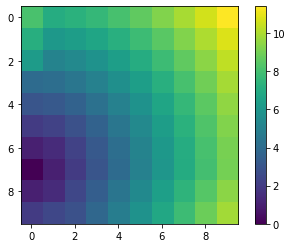

In [138]:
plt.imshow(dist[70].reshape((10,10)))
plt.colorbar()

In [139]:
path = paths_avoid_or_prefer_types(patch_net_rand,[],[],0,70)
print(path)
calculate_dist_traveled_centers(patch_net_rand,path)

[ 0 10 20 30 40 50 60 70]


7.0

In [140]:
path = paths_avoid_or_prefer_types(patch_net_rand,[2],[],0,70)
print(path)
calculate_dist_traveled_centers(patch_net_rand,path)

[ 0. 10. 20. 30. 41. 60. 70.]


7.650281539872885